## Demand Prediction

We will try training several models to predict the demand, i.e., the number of daily passengers, for different flight routes.

Import necessary libraries and packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from joblib import dump
import warnings

warnings.filterwarnings('ignore')
pd.set_option("future.no_silent_downcasting", True) # Prevent silent data type changes during operations for future compatibility

Before training models, we first transform the data.

In [3]:
# Load the cleaned data
df = pd.read_csv("../data/cleaned_data.csv")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["daily_passengers"]), df["daily_passengers"], test_size=0.2, random_state=42)

display(X_train.head())

,year,quarter,airport_1,airport_2,distance,state_1,city_1,state_2,city_2,population_1,density_1,population_2,density_2,lat_1,lon_1,lat_2,lon_2
147546,2009,4,ORD,RIC,642,IL,Chicago,VA,Richmond,8497759.0,4614.5,1073223.0,1463.7,41.775002,-87.696388,37.540759,-77.433932
12123,2006,3,DAL,PDX,1626,TX,Dallas,OR,Portland,5830932.0,1478.7,2095808.0,1868.8,40.110860,-77.035636,45.516018,-122.681425
167944,1993,3,ABQ,DCA,1670,NM,Albuquerque,DC,Washington,769986.0,1159.8,5116378.0,4235.7,35.084248,-106.649241,38.892062,-77.019912
71631,1996,3,BOS,IAH,1609,MA,Boston,TX,Houston,4328315.0,5319.0,5970127.0,1384.0,42.358894,-71.056742,29.760803,-95.369506
66928,1999,3,DAL,JAN,408,TX,Dallas,MS,Jackson,5830932.0,1478.7,335171.0,529.9,40.110860,-77.035636,30.325968,-81.656760


In [4]:
categorical_cols = ["quarter", "city_1", "city_2", "airport_1", "airport_2", "state_1", "state_2"]
unique_vals = X_train[categorical_cols].nunique()
display(unique_vals)

quarter        4
city_1       138
city_2       125
airport_1    186
airport_2    172
state_1       43
state_2       40
dtype: int64

It can be observed that most categorical variables have high cardinality values. To avoid the curse of dimensionality and efficiently deal with missing values, we use target encoding to convert categorical variables to be numeric. One-hot encoding will still be used for the `quarter` column as it only has four different nominal values. Finally, the data will be standardized before being fitted to different machine learning models.

In [5]:
# Define column groups
numeric_cols = ["year", "distance", "population_1", "density_1", "population_2", "density_2", "lat_1", "lon_1", "lat_2", "lon_2"]
low_cardinality_cols = ["quarter"]
high_cardinality_cols = ["city_1", "city_2", "airport_1", "airport_2", "state_1", "state_2"]

# Create a column transformer for categorical encodings
categorical_transformer = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output=False), low_cardinality_cols),
        ("target", TargetEncoder(random_state=42, target_type="continuous", smooth=50), high_cardinality_cols),
        ("passthrough", "passthrough", numeric_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Create a full pipeline with StandardScaler applied after encoding
preprocessing_pipeline = Pipeline(
    steps=[
        ("encoder", categorical_transformer),
        ("scaler", StandardScaler())
    ]
)

# Fit and transform the data
X_train_transformed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

In [6]:
# Create feature names
feature_names = ([f"quarter_{i}" for i in range(1, 5)] + high_cardinality_cols + numeric_cols)
X_train = pd.DataFrame(X_train_transformed, columns=feature_names, index=X_train.index)
X_test = pd.DataFrame(X_test_transformed, columns=feature_names, index=X_test.index)

display(X_train.head())

,quarter_1,quarter_2,quarter_3,quarter_4,city_1,city_2,airport_1,airport_2,state_1,state_2,year,distance,population_1,density_1,population_2,density_2,lat_1,lon_1,lat_2,lon_2
147546,-0.592028,-0.571486,-0.576259,1.755523,1.098253,-1.374191,1.717321,-0.924878,1.352323,-2.409933,0.054919,-0.779459,0.500200,0.443474,-0.828721,-0.759556,0.713284,0.127335,-0.159076,0.817684
12123,-0.592028,-0.571486,1.735332,-0.569631,0.436024,-0.288640,-0.362460,0.013739,-0.104484,-0.360314,-0.289830,0.620218,0.016706,-0.606917,-0.662790,-0.642145,0.363414,0.816499,1.530408,-1.566068
167944,-0.592028,-0.571486,1.735332,-0.569631,-0.772136,-0.006742,-0.547475,0.268853,-0.928142,0.006757,-1.783745,0.682805,-0.900841,-0.713738,-0.172653,0.043854,-0.693383,-1.097871,0.127185,0.839496
71631,-0.592028,-0.571486,1.735332,-0.569631,-0.061102,-0.173849,1.471245,0.254787,-0.069415,-0.234217,-1.438995,0.596037,-0.255718,0.679458,-0.034118,-0.782655,0.836042,1.203004,-1.807187,-0.127207
66928,-0.592028,-0.571486,1.735332,-0.569631,0.455444,-1.228839,-0.375767,-0.823625,-0.081362,-1.803863,-1.094246,-1.112309,0.016706,-0.606917,-0.948482,-1.030199,0.363414,0.816499,-1.687462,0.595215


Save the pipeline and the feature names for later use

In [7]:
dump(preprocessing_pipeline, "../models/preprocessing_pipeline.joblib")
dump(feature_names, "../models/feature_names.joblib")

['../models/feature_names.joblib']

Linear Regression with L1 Regularization:
<ul>
  <li>
    Higher interpretability: The results of a linear regression model is easier to interpret compared to other machine learning algorithms.
  </li>
  <li>
    Feature Selection: LassoCV can be particularly valuable in reducing the number of features in a model by setting coefficients of less important features to zero.
  </li>
  <li>
    Prevention of Overfitting: The L1 regularization helps prevent overfitting by constraining the size of the coefficients.
  </li>

In [15]:
lasso_cv = LassoCV(cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)

y_test_pred = lasso_cv.predict(X_test)

lasso_mse = mean_squared_error(y_test, y_test_pred)
lasso_r2 = r2_score(y_test, y_test_pred)
print("MSE:", lasso_mse)
print("R2:", lasso_r2)

MSE: 144838.97372065447
R2: 0.4368426132481338


Random Forest:
<ul>
  <li>
    Robustness: Random Forests are less prone to overfitting than many other algorithms because they average multiple deep decision trees, each trained on different parts of the same training set.
  </li>
  <li>
    Handling of Non-linear Relationships: Random Forests can handle non-linear relationships between features and the target variable without the need for transformations.
  </li>
  <li>
    Feature Handling: This algorithm can handle large data sets with higher dimensionality well; it can manage thousands of input variables without variable deletion, and it provides feature importance scores, which are helpful for understanding the factors driving predictions.
  </li>
  <li>
    Versatility: Works well with both numerical and categorical data and does not require scaling of data.
  </li>
</ul>

Due to the size and complexity of our dataset, RandomizedSearchCV was used to search for the optimal hyperparameters.

In [18]:
rf = RandomForestRegressor()
param_distributions = {
    'n_estimators': np.arange(100, 200, 300),
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, 30, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

y_test_pred = rf_search.predict(X_test)

rf_mse = mean_squared_error(y_test, y_test_pred)
rf_r2 = r2_score(y_test, y_test_pred)
print("MSE:", rf_mse)
print("R2:", rf_r2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  31.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  31.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  31.4s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  48.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  48.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  48.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  30.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estim

Gradient Boosting:
<ul>
  <li>
    Performance: Often provides superior predictive accuracy thanks to its efficient handling of various data types and distributions. XGBoost is known for winning many machine learning competitions due to its effectiveness.
  </li>
  <li>
    Regularization: XGBoost includes built-in L1 and L2 regularization which helps prevent overfitting, which is crucial for high-dimensional data.
  </li>
  <li>
    Scalability: XGBoost is designed to be highly efficient, scalable, and fast, even over large datasets.
  </li>
</ul>

Due to the size and complexity of our dataset, RandomizedSearchCV was used to search for the optimal hyperparameters.

In [19]:
xgb_model = xgb.XGBRegressor()
param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions, n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
xgb_search.fit(X_train, y_train)
y_test_pred = xgb_search.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_test_pred)
xgb_r2 = r2_score(y_test, y_test_pred)
print("MSE:", xgb_mse)
print("R2:", xgb_r2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6; total time=   9.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6; total time=  10.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6; total time=  10.3s
[CV] END colsample_bytree=0.75, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=1.0; total time=  14.9s
[CV] END colsample_bytree=0.75, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=1.0; total time=  15.1s
[CV] END colsample_bytree=0.75, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=1.0; total time=  15.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=0.8; total time=  15.8s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=0.8; total time=  16.4s
[CV] END cols

Neural Network

In [11]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


2024-12-08 17:36:08.873038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4920/4920 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 163977.3438 - val_loss: 106968.0547
Epoch 2/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 107068.0859 - val_loss: 97201.8359
Epoch 3/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 98602.7812 - val_loss: 90421.4219
Epoch 4/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 93913.2500 - val_loss: 83514.1875
Epoch 5/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 85250.1641 - val_loss: 78301.1172
Epoch 6/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 78607.2188 - val_loss: 75252.0391
Epoch 7/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 76557.0469 - val_loss: 70715.2578
Epoch 8/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 72372.8516 - val_loss: 68159.6641
Epoch 9/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 72107.4844 - val_loss: 65980.8047
Epoch 10/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 69934.5391 - val_loss: 64548.4570
Epoch 11/100
4920/4920 ━━━━━

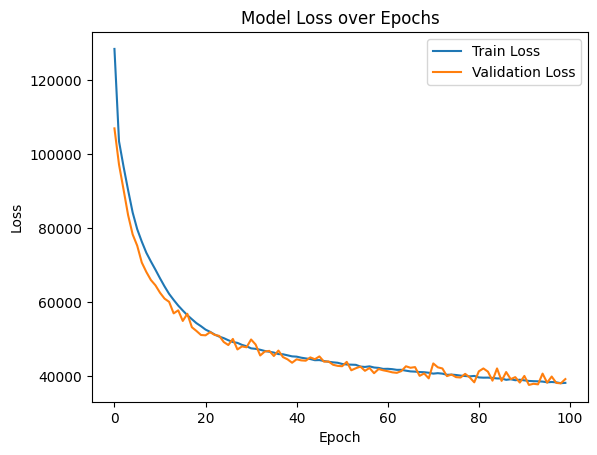

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [13]:
y_test_pred = model.predict(X_test).flatten()
nn_mse = mean_squared_error(y_test, y_test_pred)
nn_r2 = r2_score(y_test, y_test_pred)
print("MSE:", nn_mse)
print("R2:", nn_r2)

1538/1538 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
MSE: 40427.20122598107
R2: 0.8428124785423279


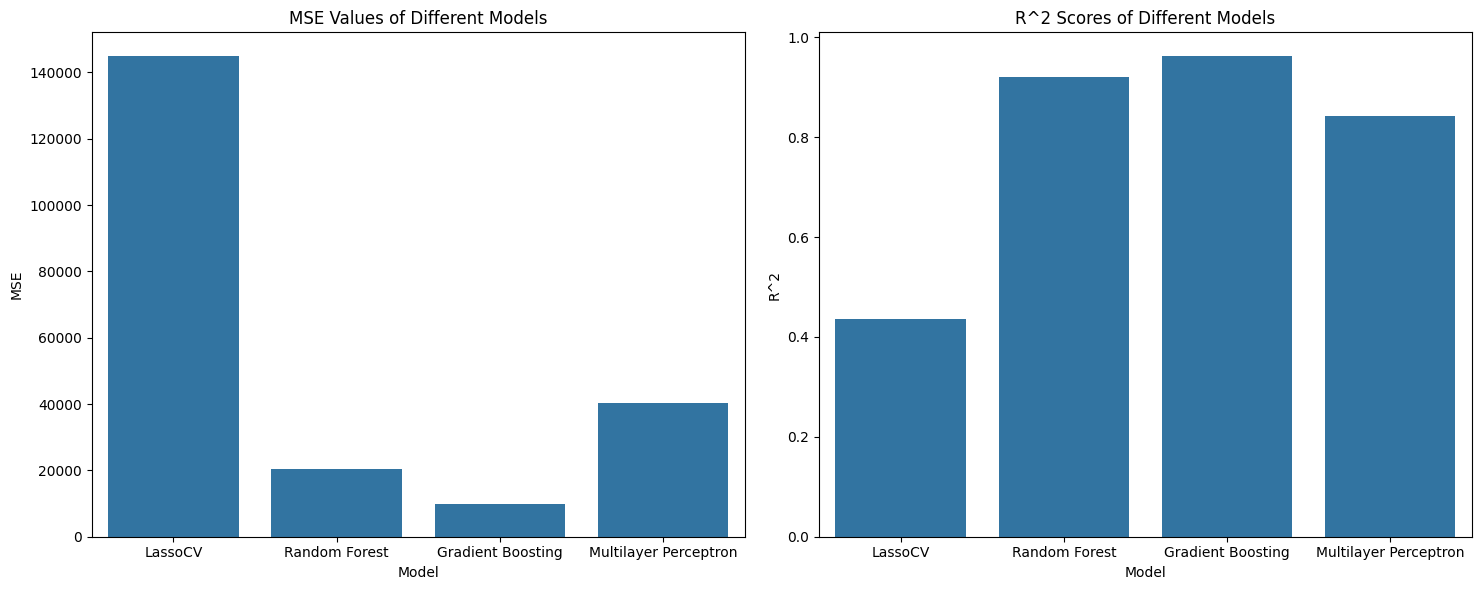

In [26]:
# Define the model names and their corresponding MSE and R2 scores
model_names = ["LassoCV", "Random Forest", "Gradient Boosting", "Multilayer Perceptron"]
mse_values = [lasso_mse, rf_mse, xgb_mse, nn_mse]
r2_values = [lasso_r2, rf_r2, xgb_r2, nn_r2]

# Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Model': model_names,
    'MSE': mse_values,
    'R2': r2_values
})

# Plot the MSE values
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MSE', data=results_df)
plt.title('MSE Values of Different Models')
plt.ylabel('MSE')
plt.xlabel('Model')

# Plot the R2 values
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R2', data=results_df)
plt.title('R^2 Scores of Different Models')
plt.ylabel('R^2')
plt.xlabel('Model')

plt.tight_layout()
plt.show()

Since the Gradient Boosting algorithm has performed the best on the test dataset, we will be using this model to predict the passenger demand for different flight routes.

In [27]:
# Save the model for later use
dump(xgb_search, "../models/demand_prediction_model.joblib")

['../models/demand_prediction_model.joblib']